# Tutorial 1 - Linear Regression

This tutorial illustrates how *swyft* can be used to estimate 1-dim and 2-dim marginal posteriors for a simple linear regression model. The same framework can be also used to analyse, e.g., image or other complex data.  The *swfty* API is somewhat verbose right now, which emphasizes the internal workings.  We plan to change this soon.

## Imports

In [1]:
# Install swyft when on google colab
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [2]:
# Standard imports
import numpy as np
import pylab as plt
from scipy import stats
import torch

# Import swyft
import swyft
DEVICE = swyft.set_device(gpu=True)

## Linear Regression Example

### Priors

We are interested in Bayesian parameter inference, so let's first get our priors straight.  In its current version, *swyft* always assumes that model parameter $\mathbf{z}$ live with *uniform prior* on the hypercube, i.e. $z_i \in [0, 1]$.

### Our "physics simulator"

We consider a simple linear regression problem.  To this end, we define a "line simulator", which produces a line giving two input parameters (corresponding to offset and slope).

In [3]:
def simulator(z):
    "Line simulator"
    p = np.linspace(-1, 1, 10)  # Nbin = 10
    mu = z[0]*2-1 + p*(z[1]*2-1)
    return mu

The simulator generates beautiful lines.

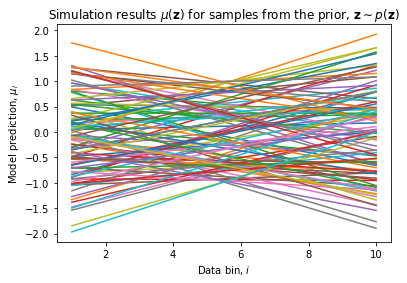

In [4]:
for _ in range(100):
    z = np.random.rand(2)
    plt.plot(range(1, 11), simulator(z));
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Simulation results ${\mu}(\mathbf{z})$ for samples from the prior, $\mathbf{z}\sim p(\mathbf{z})$");

Assuming that measurement errors for each data bin are Gaussian, a typical likelihood-based analysis would now exploit the $\chi^2$ function
$$
\chi^2 = -2\ln p(\mathbf{x}_0|\mathbf{z}) = \sum_{i=1}^{N_\text{bins}} \frac{(\mu_i(\mathbf{z}) - x_{0,i})^2}{\sigma^2}\;,
$$
where $\mathbf{x}_0$ referes to the measured flux, $\boldsymbol{\mu}(\mathbf{z})$ is the result of the line simulator model given model parameters $\textbf{z}$, $\sigma$ refers to the standard deviation of the measurement noise, and $N_\text{bins} = 10$ is the number of bins. This is *not* will do here.

### Our "detector noise"

Instead, a likelihood-free (or simulator based) analysis is based on random draws from the likelihood (aka *forward model*), $\mathbf{x}\sim p(\mathbf{x}|\mathbf{z})$.  Since we are assuming in the current example that measurement noise is Gaussian, we just have to add zero-mean Gaussian noise to the simulator results.  We do this with a separate function.

In [5]:
def noise(mu, z = None, sigma=0.1):
    n = np.random.randn(*mu.shape)*sigma
    x = mu + n
    return x

Now we can generate noisy lines!

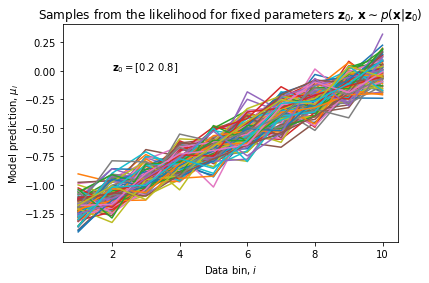

In [6]:
z0 = np.array([0.2, 0.8])  # Some fixed parameters

for _ in range(100):
    plt.plot(range(1, 11), noise(simulator(z0)));
plt.annotate("$\mathbf{z}_0 =$"+str(z0), (2, 0));
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Samples from the likelihood for fixed parameters $\mathbf{z}_0$, $\mathbf{x} \sim p(\mathbf{x}|\mathbf{z}_0)$");

### The generative model

Data scientists sometimes talk about *generative models*.  For us, this refers simply to a sampler that both generates a random draw from the prior, $p(\mathbf{z})$, and subsequently a corresponding random draw from the forward model: $\mathbf{x}, \mathbf{z} \sim p(\mathbf{x}|\mathbf{z}) p(\mathbf{z})$.
Such $(\mathbf{x},\mathbf{z})$ pairs are samples from the generative model.  Drawing from the generative model and throwing away $\mathbf{z}$ is equivalent to sampling from the marginal likelihood (aka Bayesian evidence), $\mathbf{x} \sim p(\mathbf{x})$.

Let us plot random samples from the marginal likelihood!  We also show in red a sample from the forward model for our specific reference parameters ($\mathbf{z}_0$): $\mathbf{x}_0 \sim p(\textbf{x}|\textbf{z}_0)$.

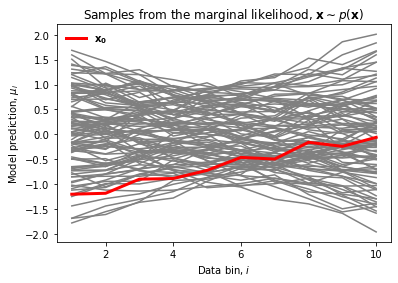

In [7]:
for _ in range(100):
    plt.plot(range(1, 11), noise(simulator(np.random.rand(2))), color='0.5');
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Samples from the marginal likelihood, $\mathbf{x} \sim p(\mathbf{x})$");

# Define mock data
x0 = noise(simulator(z0))
plt.plot(range(1, 11), x0, lw = 3, color='r', label = "$\mathbf{x_0}$")
plt.legend(frameon = False);

Additional information: The noise could be also simulated within the function `simulator`, and the function `noise` could just do nothing. However, often the physics simulation is slow, but adding (Gaussian, Poission, etc) measurement noise is fast.  In these cases the split functions enable to train networks with different noise realizations without rerunning the simulator.  The basic logic is: simulator = slow, noise = fast.

## Step-by-step parameter estimation with *swyft* (verbose and without nesting)

Now we are ready to solve the inverse problem and derive the posterior $p(\mathbf{z}|\mathbf{x}_0)$, using *swyft*.  Let's do this step-by-step to highlight the important steps.  We will consider nesting as well as a convenience function for doing everything in one go further below.

### Instantiating the iP3 sample cache

First we have to instantiate a simulation cache, which is the place where all simulation results are stored. *swyft* offers the options to store them on disk (for later re-use) for simply in memory.  We chose the memory option here.

In [8]:
cache = swyft.MemoryCache(zdim = 2, xshape = x0.shape)

Creating new cache.


### Filling iP3 sample cache with simulated data

The next step is to fill the iP3 sample cache with simulations over the complete prior range.  We do this by first generating an intensity object that covers the complete prior, then adding the necessary parameters points to the cache, and finally running the simulator for the newly added points.

Note: Run this cell twice and see what happens.

In [85]:
intensity = swyft.get_unit_intensity(expected_n=2000, dim=2)
cache.grow(intensity)
cache.simulate(simulator)

No new simulator runs required.
No simulations required.


### Extract training data from cache

We instantiate a `Points` object that pulls out the training data from the sample cache.  We also add the noise model here, which will be run each time a sample is picked from the point list.

In [86]:
points = swyft.Points(cache, intensity, noise)
print("Number of simulations in `points`:", len(points))

No new simulator runs required.
Number of simulations in `points`: 1997


### Estimate 1-dim marginal posteriors using a ratio estimator

We are now ready to instantiate a ratio estimator object and train it on the simulated points.

In [87]:
re = swyft.RatioEstimator(points, device=DEVICE)
re.train(max_epochs=10, batch_size=16, lr_schedule=[1e-3, 1e-4])

yshape (shape of features between head and legs): 10
Start training
LR iteration 0
Validation loss: 25.003363132476807
Validation loss: 20.5330628156662
Validation loss: 24.693928718566895
Total epochs: 3
LR iteration 1
Validation loss: 18.855608105659485
Validation loss: 17.811644554138184
Validation loss: 18.75757110118866
Total epochs: 3


### Plot 1-dim marginal posteriors

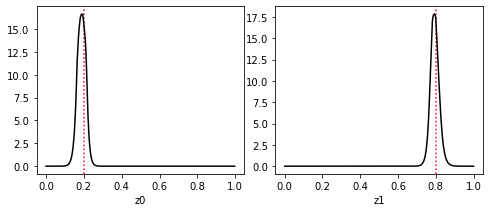

In [88]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (8, 3), ncol = 2, params = [0, 1])

Comparison of inferred errors (68% credible interval half-width) with expected 1-sigma uncertainty from Fisher forecasting

In [89]:
swyft.cred1d(re, x0 = x0)

z0 = 0.18842 +- 0.02232
z1 = 0.79367 +- 0.02209


In [90]:
print("Fisher uncertainty for z_0 = %.5f"%(0.1/((2*np.ones(10))**2).sum()**0.5))  # Based on Fisher forecasting
print("Fisher uncertainty for z_1 = %.5f"%(0.1/((2*np.linspace(-1, 1, 10))**2).sum()**0.5))  # Fisher forecasting

Fisher uncertainty for z_0 = 0.01581
Fisher uncertainty for z_1 = 0.02477


It turns out that the estimated posteriors are wider than what is expected from Fisher forecasting. Given the very low number of training samples (just a 1000), this is no surprise.  There are two ways to fix this:
- Increase the amount of training data (try e.g. 10000 instead of 1000 above and re-run)
- Zoom into the relevant prefered parameter range, simulate more training data there, and train a new targeted ratio estimator

We will try the second option next.

## Nested parameter estimation with *swyft*

### A nested analysis loop

The next function implements the required analysis steps for a nested analysis.  Beyond what was discussed above, the only new ingreedient is the function `get_constrained_intensity`, which generates an intensity object constrained to the interesting prior region, given some observation `x0` and a ratio estimator.

In [99]:
def run(x0, simulator, noise = None, cache = None, n_train = 10000, zdim = None, n_rounds = 3, device = 'cpu', max_epochs = 10, batch_size = 16,  lr_schedule = [1e-3, 1e-4]):
    if cache is None:
        cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)
    intensities = []
    res = []
    intensity = swyft.get_unit_intensity(expected_n=n_train, dim=zdim)
    intensities.append(intensity)
    for i in range(n_rounds):
        if i == 0:
            intensity = swyft.get_unit_intensity(expected_n=n_train, dim=zdim)
        else:
            intensity = swyft.get_constrained_intensity(expected_n=n_train, ratio_estimator=res[-1], x0=x0, threshold=1e-5)
        intensities.append(intensity)   
        cache.grow(intensities[-1])
        cache.simulate(simulator)
        points = swyft.Points(cache, intensities[-1], noise)
        re = swyft.RatioEstimator(points, device=device)
        res.append(re)
        res[-1].train(max_epochs=max_epochs, batch_size=batch_size, lr_schedule=lr_schedule)
    return points, res[-1]

The function `run` takes as input the target observation $\mathbf{x}_0$, the dimensionality of the parameter space $\mathbf{z}$, the simulator function and the (optional) noise function.

The analysis steps involve:
- Creation of simulation cache in memory
- Filling the simulation cache with parameter samples from the prior
- Running simulations for these parameter samples
- Training a neural network to estimate the posterior

Let's run the analysis for three rounds.

In [ ]:
points, re = run(x0, simulator, zdim = 2, noise = noise, device = DEVICE, n_train = 20000)

Simulate:   0%|          | 0/20095 [00:00<?, ?it/s]

Creating new cache.
Adding 20095 new samples. Run simulator!


Simulate: 100%|██████████| 20095/20095 [00:14<00:00, 1423.10it/s]


yshape (shape of features between head and legs): 10
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 187.05194196105003
Validation loss: 183.84666666388512


### Plot 1-dim posteriors

In [ ]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (8, 3), ncol = 2, params = [0, 1])
swyft.cred1d(re, x0 = x0)

Results evidently got better.  More training data will further help.

### Plot 2-dim posteriors

in order to estimate 2-dim posteriors, we use the points from the last round of the 1-dim analysis.

In [ ]:
# 2-dim posteriors
re2 = swyft.RatioEstimator(points, combinations = [[0, 1]], device=DEVICE)
re2.train(max_epochs=5, batch_size=16, lr_schedule=[1e-3, 3e-4, 1e-4])

This will be the basis for a nice corner plot.

In [ ]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 10, max_n_points = 10000)